In [1]:
import os
import sys

sys.path.append('..')

In [2]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

In [3]:
%matplotlib inline
# %matplotlib widget

In [4]:
DATA_ROOT = '../tests/data/preprocess_demo'
print(os.path.exists(DATA_ROOT))

True


In [5]:
mask_fn = 'cropped_aachen_000000_000019_labelIds.png'  # cropped
mask_fn = 'case2.png'  # cropped
mask_fn = 'aachen_000000_000019_gtFine_labelIds.png'
gt_edge_fn = 'aachen_000000_000019_gtProc_edge.png'

# mask_fn = 'bochum_000000_000313_gtFine_labelIds.png'
# gt_edge_fn = 'bochum_000000_000313_gtProc_edge.png'

mask_path = os.path.join(DATA_ROOT, mask_fn)
edge_path = os.path.join(DATA_ROOT, gt_edge_fn)
print(os.path.exists(mask_path))
print(os.path.exists(edge_path))

True
True


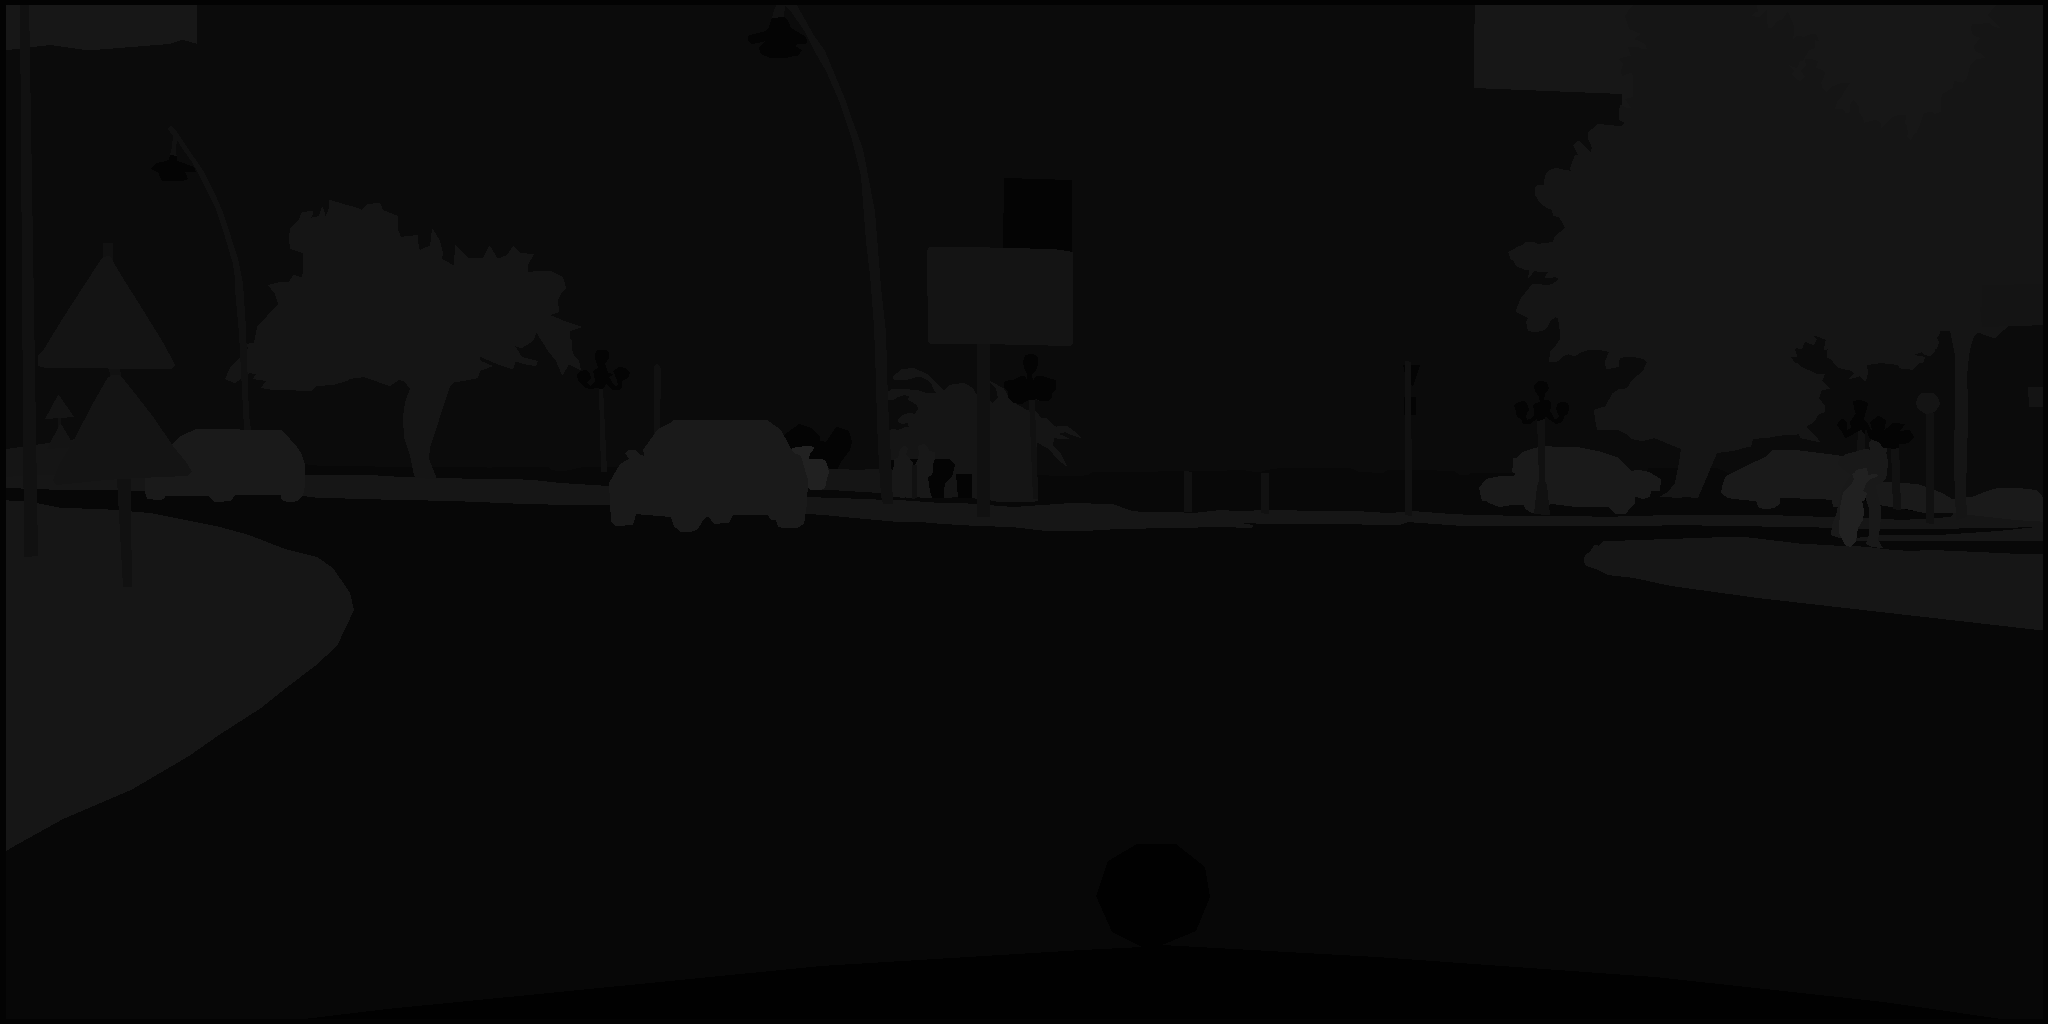

In [6]:
mask_img = Image.open(mask_path)
mask = np.array(mask_img)
display(mask_img)

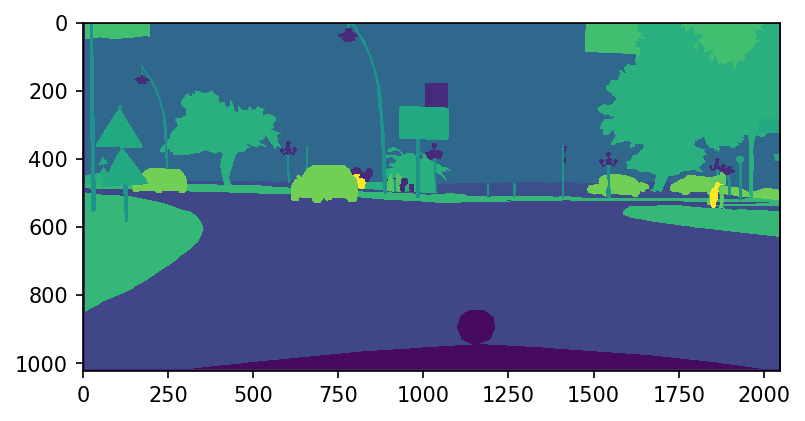

In [7]:
plt.imshow(mask, interpolation='nearest')
plt.gcf().set_dpi(150)
# plt.savefig('seg.pdf')

In [8]:
# from scipy.ndimage.morphology import distance_transform_edt
import cv2  # NOTE: use cv2 instead of scipy
from copy import deepcopy

In [9]:
import pyEdgeEval
pyEdgeEval.__file__

'../pyEdgeEval/__init__.py'

In [15]:
from pyEdgeEval.utils import mask2onehot
from pyEdgeEval.common.multi_label.dataset_attributes import CITYSCAPES_labelIds, CITYSCAPES_label2trainId

In [16]:
h, w = mask.shape

In [17]:
m = mask2onehot(mask, CITYSCAPES_labelIds)

inner


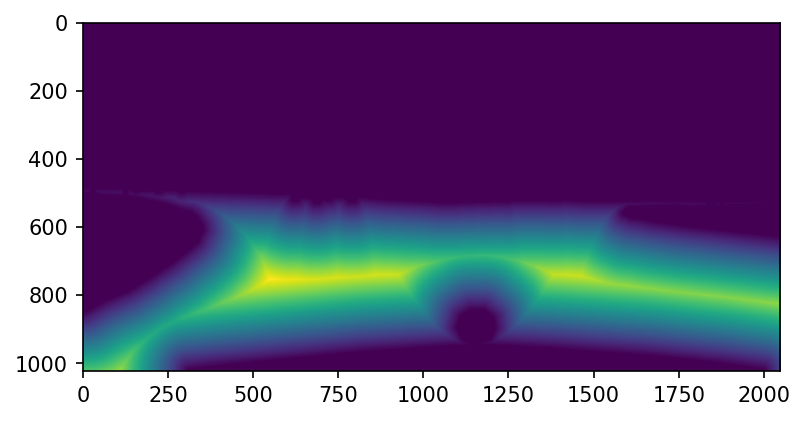

False
outer


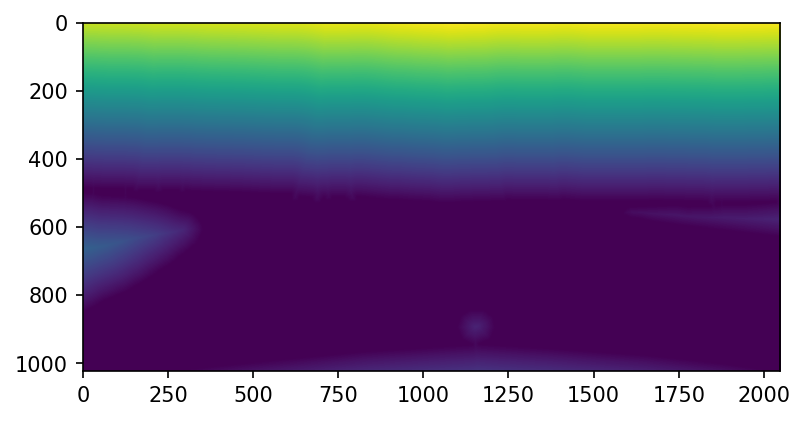

dist


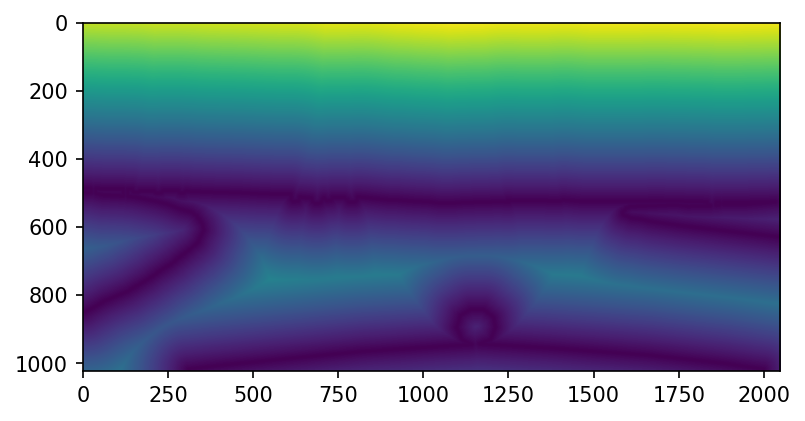

thresholded


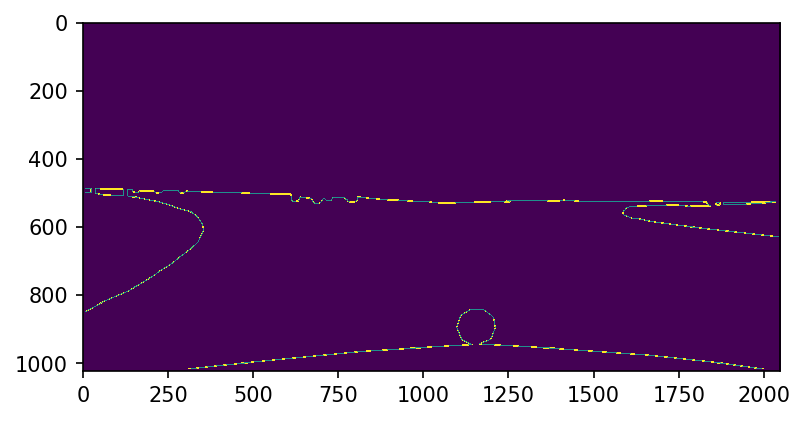

binarize


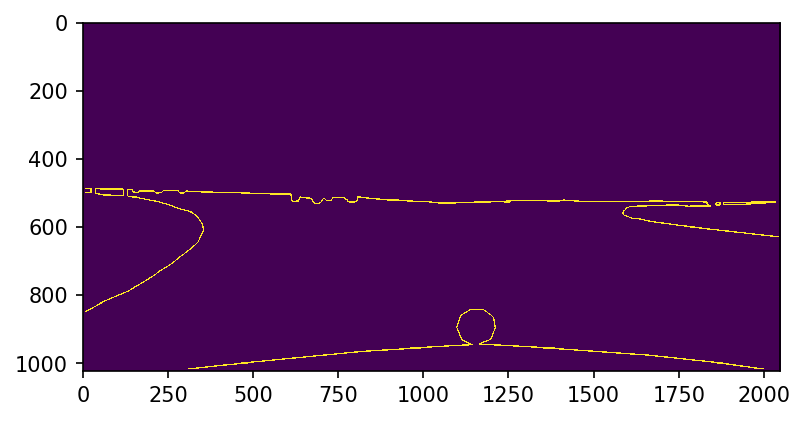

In [18]:
testing = True
tmp_class = 7

inner = None
outer = None
dist = None

if testing:
    # inner = distance_transform_edt(m[tmp_class, ...])
    # inner = distance_transform_edt(
    #     deepcopy(
    #         m[tmp_class, ...] + m[3, ...] + m[2, ...]
    #     )
    # )
    
    # we add ignore labels to inner
    _m = m[tmp_class, ...] + m[3, ...] + m[2, ...]
    _m = (_m > 0).astype(np.uint8)
    inner = cv2.distanceTransform(_m, cv2.DIST_L2, 0)  # maskSize is 0 (precise), 3 (3x3), or 5 (5x5)
    # print('debug', m[tmp_class, ...]) #+ m[3, ...] + m[2, ...])
    
    
    print("inner")
    plt.imshow(inner, interpolation='nearest')
    plt.gcf().set_dpi(150)
    plt.show()
    
    
    print(np.allclose(1 - m[tmp_class, ...], np.ones((h, w))))
    inv = 1 - m[tmp_class, ...]
    if np.sum(inv) == h*w:
        print("1s")
        inv = np.zeros((h, w))
    
    # outer = distance_transform_edt(deepcopy(inv))
    outer = cv2.distanceTransform(inv, cv2.DIST_L2, 0)
    
    print("outer")
    plt.imshow(outer, interpolation='nearest')
    plt.gcf().set_dpi(150)
    plt.show()
    
    # dist = outer * ignore_mask + (inner)
    dist = outer + (inner)
    
    print("dist")
    plt.imshow(dist, interpolation='nearest')
    plt.gcf().set_dpi(150)
    # plt.savefig('dist.pdf')
    plt.show()
    
    dist[dist > 2] = 0

    print("thresholded")
    plt.imshow(dist, interpolation='nearest')
    plt.gcf().set_dpi(150)
    plt.show()
    
    bin_dist = (dist > 0).astype(np.uint8)
    
    print("binarize")
    plt.imshow(bin_dist, interpolation='nearest')
    plt.gcf().set_dpi(150)
    plt.show()

In [19]:
def onehot_to_multiclass_edges(
    mask: np.ndarray,
    radius: int = 2,
    num_classes: int = 34,
    ignore_classes: list = [2, 3],
    quality: int = 0,
) -> np.ndarray:
    """
    Converts a segmentation mask (K,H,W) to an edgemap (K,H,W)
    """
    if radius < 1:
        return mask

    h, w = mask.shape[1:]

    # make ignore mask
    ignore_mask = np.zeros((h, w), dtype=np.uint8)
    for i in ignore_classes:
        ignore_mask += mask[i]

    edges = np.zeros_like(mask)
    for c in range(num_classes):
        if c in ignore_classes:
            continue

        if not np.count_nonzero(mask[c]):
            # if there are no class labels in the mask
            continue

        inner = cv2.distanceTransform(((mask[c] + ignore_mask) > 0).astype(np.uint8), cv2.DIST_L2, quality)
        outer = cv2.distanceTransform(((1. - mask[c]) > 0).astype(np.uint8), cv2.DIST_L2, quality)
        dist = outer + inner

        dist[dist > radius] = 0
        dist = (dist > 0).astype(np.uint8)

        edges[c] = dist

    return edges


In [20]:
%%timeit
_ = onehot_to_multiclass_edges(m, 2, 34, quality=0)

175 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
%%timeit
_ = onehot_to_multiclass_edges(m, 2, 34, quality=3)

421 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
_ = onehot_to_multiclass_edges(m, 2, 34, quality=5)

198 ms ± 309 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%time

edges_ids = onehot_to_multiclass_edges(m, 2, 34, quality=5)

CPU times: user 190 ms, sys: 8.1 ms, total: 198 ms
Wall time: 197 ms


In [24]:
print(edges_ids.shape)

(34, 1024, 2048)


In [26]:
from pyEdgeEval.common.multi_label.edge_encoding import rgb_multilabel_encoding

In [27]:
# debug
print(edges_ids.shape, m.shape, mask.shape)

(34, 1024, 2048) (34, 1024, 2048) (1024, 2048)


In [28]:
edges_trainIds = np.zeros((19, h, w), dtype=np.uint8)
for labelId, trainId in CITYSCAPES_label2trainId.items():
    edges_trainIds[trainId] = edges_ids[labelId, ...]

In [29]:
encoded_edges = rgb_multilabel_encoding(edges_trainIds)

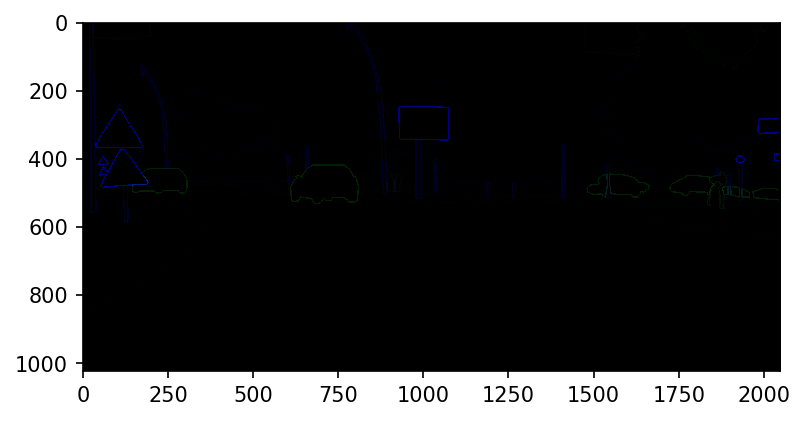

In [30]:
plt.imshow(encoded_edges, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [31]:
bin_edges = (np.sum(edges_trainIds, axis=0) > 0).astype(np.uint8)
_bin_edges = (np.sum(edges_ids, axis=0) > 0).astype(np.uint8)

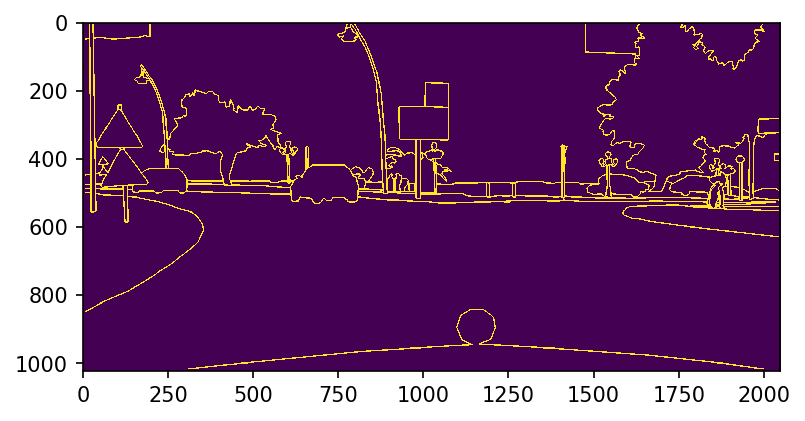

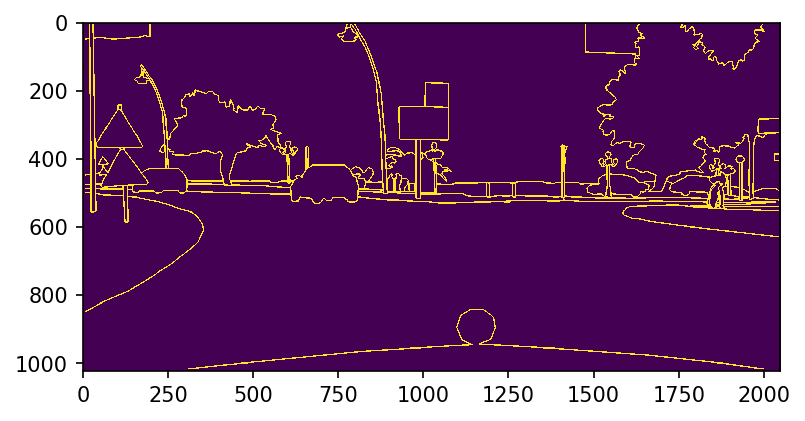

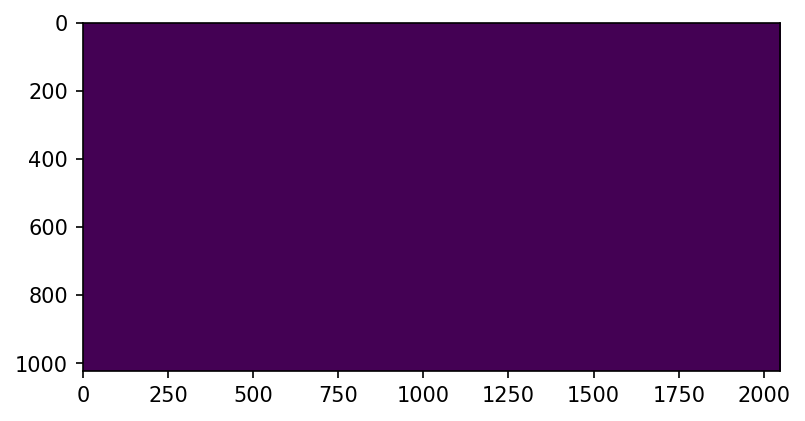

In [32]:
plt.imshow(bin_edges, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(_bin_edges, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(edges_trainIds[4], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [120]:
edge_img = Image.open(edge_path)
print(edge_path)
# display(edge_img)

../tests/data/preprocess_demo/bochum_000000_000313_gtProc_edge.png


In [121]:
# tif
# gt_edge = np.array(edge_img).astype(np.uint32)
# gt_edge = gt_edge[:, :, None]
# gt_edge = np.unpackbits(
#     gt_edge.view(np.uint8),
#     axis=2,
#     count=19,
#     bitorder='little',
# )

# png
gt_edge = np.array(edge_img, dtype=np.uint8)
# check equal
print('diffs', np.count_nonzero(gt_edge != encoded_edges))
print('is equal', np.array_equal(encoded_edges, gt_edge))

print(gt_edge.shape)
gt_edge = np.unpackbits(
    gt_edge,
    axis=2,
)[:, :, -1:-20:-1]
print(gt_edge.shape)


gt_edge = np.transpose(gt_edge, (2, 0, 1))

print(gt_edge.shape)

diffs 0
is equal True
(1024, 2048, 3)
(1024, 2048, 19)
(19, 1024, 2048)


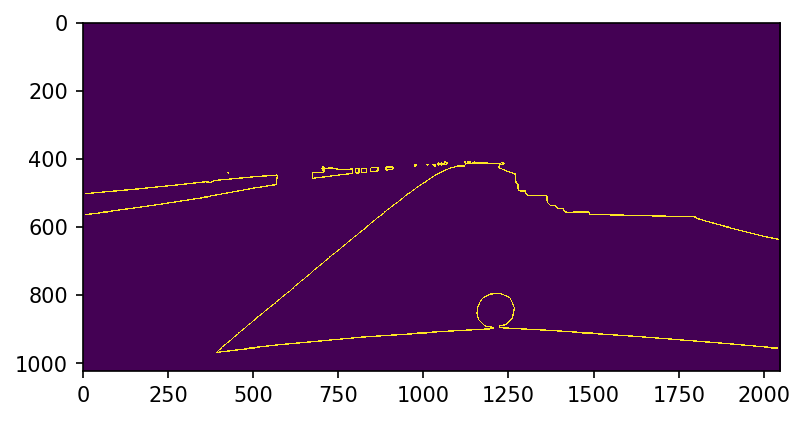

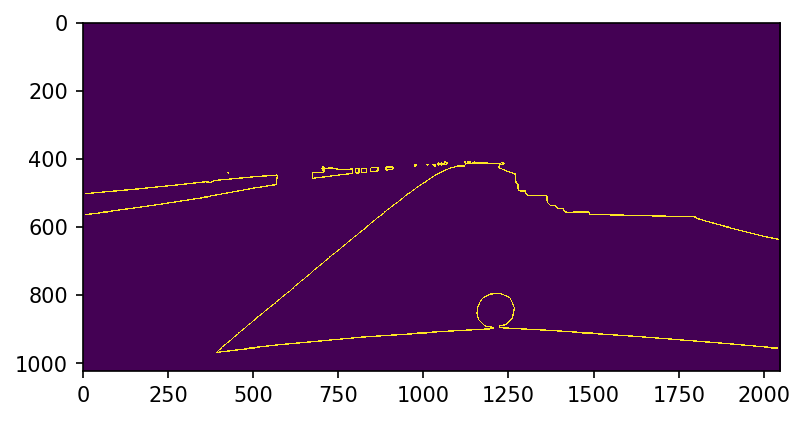

In [122]:
trainId = 0

plt.imshow(edges_trainIds[trainId], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(gt_edge[trainId], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [77]:
print('diffs', np.count_nonzero(edges_trainIds != gt_edge))
print('is close', np.allclose(edges_trainIds, gt_edge))
print('is equal', np.array_equal(edges_trainIds, gt_edge))

diffs 0
is close True
is equal True


In [78]:
# compare binary edges

gt_bin_edges = (np.sum(gt_edge, axis=0) > 0).astype(np.uint8)

print('diffs', np.count_nonzero(bin_edges != gt_bin_edges))
print('is equal', np.array_equal(bin_edges, gt_bin_edges))

diffs 0
is equal True


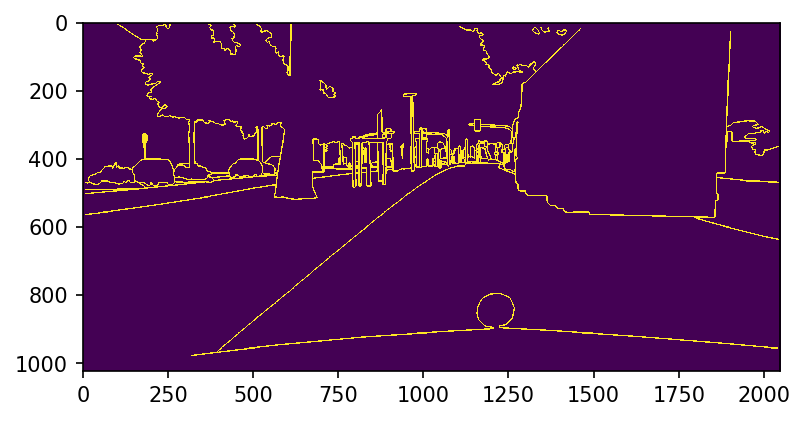

In [79]:
plt.imshow(gt_bin_edges, interpolation='nearest')
plt.gcf().set_dpi(150)

In [80]:
yx = np.where(bin_edges != gt_bin_edges)

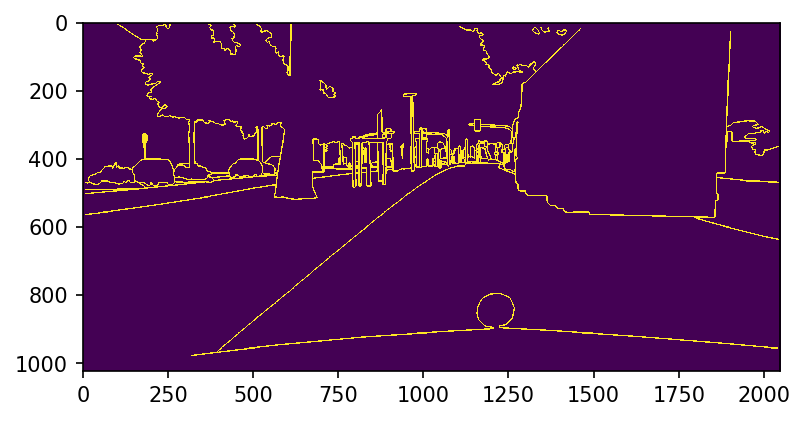

In [81]:
plt.imshow(bin_edges, interpolation='nearest')
plt.scatter(yx[1], yx[0], marker='o')
plt.gcf().set_dpi(150)
plt.show()

In [82]:
# check mmcv
import mmcv

In [83]:
file_client = mmcv.FileClient(**dict(backend="disk"))

In [84]:
img_bytes = file_client.get(edge_path)

In [85]:
m_edge_img = mmcv.imfrombytes(img_bytes, flag="color", backend="pillow", channel_order="rgb").squeeze().astype(np.uint8)

# check equal
print('diffs', np.count_nonzero(m_edge_img != encoded_edges))
print('is equal', np.array_equal(encoded_edges, m_edge_img))

diffs 0
is equal True


In [86]:
m_edge_img.shape

(1024, 2048, 3)

In [87]:
# need to check rescale
scale = 0.75
print(h, w)
resized_img = mmcv.imresize(m_edge_img, (int(w*scale), int(h*scale)), interpolation="nearest")
print(resized_img.shape)

1024 2048
(768, 1536, 3)


In [88]:
from scipy.ndimage import binary_dilation, binary_erosion, generate_binary_structure

In [89]:
resized = np.unpackbits(
    resized_img,
    axis=2,
)[:, :, -1:-20:-1]

resized = np.transpose(resized, (2, 0, 1))

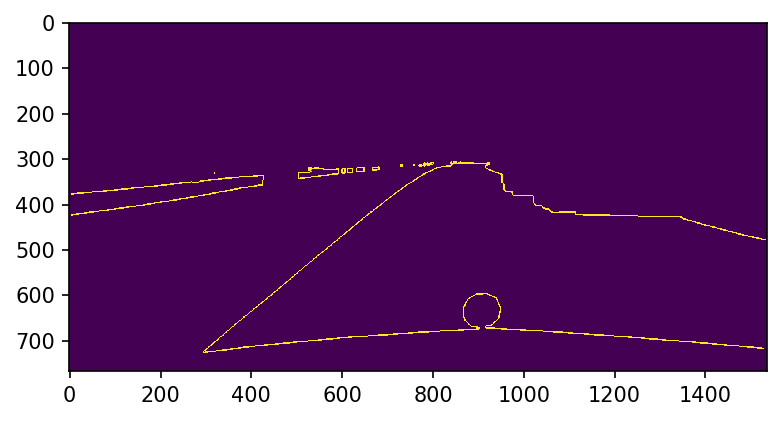

In [90]:
trainId = 0

plt.imshow(resized[trainId,], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [94]:
%%time

num_classes, _, _ = resized.shape

struct = generate_binary_structure(2, 1)

edge_enhance = np.zeros_like(resized)

for c in range(num_classes):
    if scale < 1:
        edge_enhance[c] = binary_dilation(resized[c], structure=struct)
    elif scale > 1:
        # FIXME: not needed
        edge_enhance[c] = binary_erosion(resized[c], structure=struct)

CPU times: user 245 ms, sys: 492 µs, total: 246 ms
Wall time: 244 ms


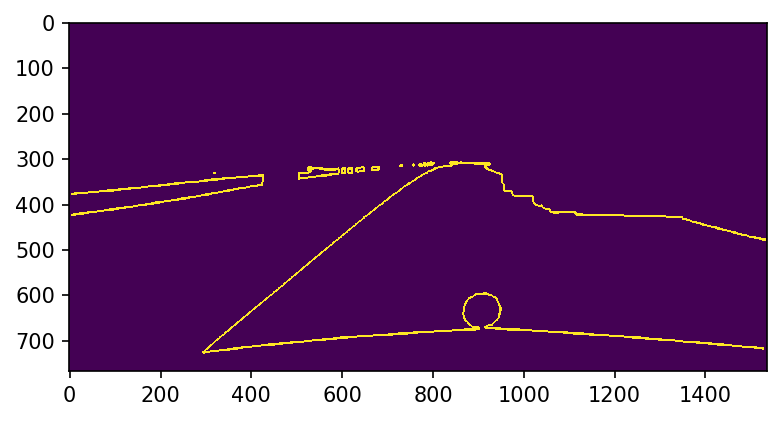

In [95]:
trainId = 0

plt.imshow(edge_enhance[trainId,], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [96]:
import cv2

In [97]:
kernel = [[0, 1, 0], [1, 1, 1], [0, 1, 0]]
kernel = np.asarray(kernel, dtype=np.uint8)

num_classes, _, _ = resized.shape

edge_enhance_cv2 = np.zeros_like(resized)

for c in range(num_classes):
    if scale < 1:
        edge_enhance_cv2[c] = cv2.dilate(resized[c], kernel, iterations=1)
    elif scale > 1:
        # FIXME: not needed
        edge_enhance_cv2[c] = cv2.erode(resized[c], kernel, iterations=1)

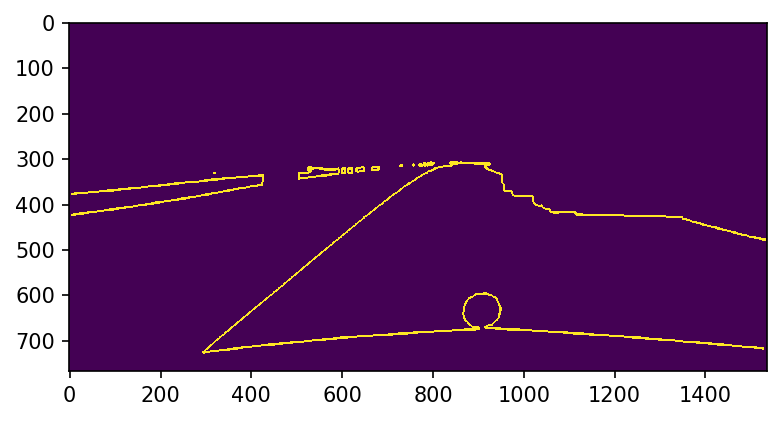

In [98]:
trainId = 0

plt.imshow(edge_enhance_cv2[trainId,], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

resize -> dilate or erode

dilate or erode -> resize

In [99]:
%%time

new_img = deepcopy(m_edge_img)
if scale < 1:
    new_img = cv2.dilate(new_img, kernel, iterations=1)
new_img = mmcv.imresize(new_img, (int(w*scale), int(h*scale)), interpolation="nearest")
new_img = np.unpackbits(
    new_img,
    axis=2,
)[:, :, -1:-20:-1]
new_img = np.transpose(new_img, (2, 0, 1))

CPU times: user 24.5 ms, sys: 1.01 ms, total: 25.5 ms
Wall time: 14.2 ms


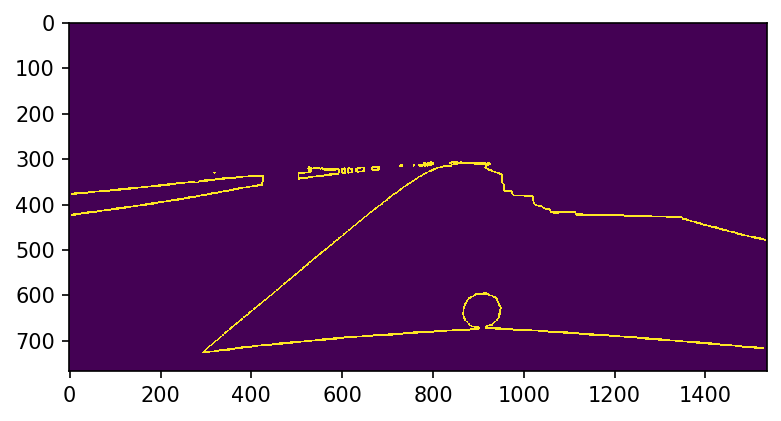

In [100]:
trainId = 0

plt.imshow(new_img[trainId,], interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [101]:
print('diffs', np.count_nonzero(edge_enhance_cv2 != edge_enhance))
print('is equal', np.array_equal(edge_enhance_cv2, edge_enhance))

diffs 0
is equal True


In [102]:
print('diffs', np.count_nonzero(edge_enhance_cv2 != new_img))
print('is equal', np.array_equal(edge_enhance_cv2, new_img))

diffs 12848
is equal False
